In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime

In [2]:
yellow_201701_df =  pd.read_csv("summary_201701.csv" ,low_memory=False, encoding = 'ISO-8859-1' )

yellow_201701_df['pickup_time'] = pd.to_datetime(yellow_201701_df['pickup_time'])

In [3]:
each_hour_df = pd.DataFrame()
each_hour_df = yellow_201701_df.groupby(by=yellow_201701_df['pickup_time'].dt.hour)['tip'].sum().reset_index(name='tips')
each_hour_df['trip_count'] =  yellow_201701_df.groupby(by=yellow_201701_df['pickup_time'].dt.hour).count()['pickup_time'].values
each_hour_df['avg_tips'] = each_hour_df['tips']/each_hour_df['trip_count']
each_hour_df

,pickup_time,tips,trip_count,avg_tips
0,0,574473.39,201862,2.845872
1,1,410879.52,151828,2.706217
2,2,308337.64,116080,2.656251
3,3,224126.27,81206,2.759972
4,4,177595.33,53482,3.320656
5,5,208995.00,57026,3.664907
6,6,377535.71,136901,2.757728
7,7,614381.45,249764,2.459848
8,8,770072.14,315434,2.441310
9,9,754991.96,304126,2.482497


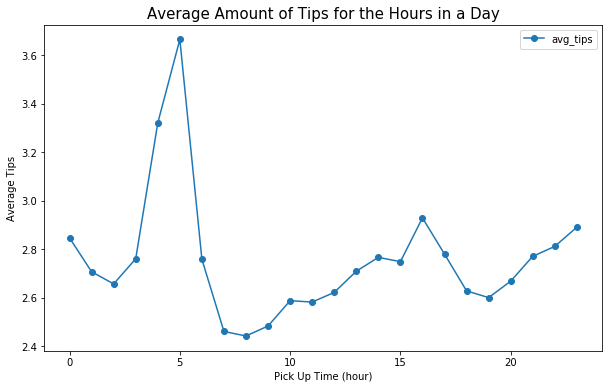

In [4]:
fig, ax = plt.subplots(1, figsize=(10, 6))
each_hour_df.plot(x='pickup_time', y=['avg_tips'], kind='line', style="-o", ax = ax)
plt.title("Average Amount of Tips for the Hours in a Day", fontdict={'fontsize': '15', 'fontweight': '3'})
plt.xlabel("Pick Up Time (hour)")
plt.ylabel("Average Tips")
plt.show()            
fig.savefig('Average_Tips_Hours.png', dpi=300)

Glen Oaks
Newark Airport
Willets Point
Manhattan Beach
Whitestone
Schuylerville/Edgewater Park
Saint Michaels Cemetery/Woodside
Sunset Park East
Hillcrest/Pomonok
Laurelton


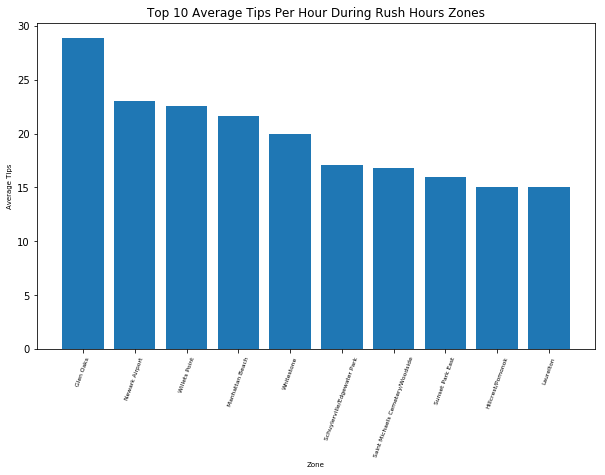

In [17]:
yellow_201701_df.head()

#load shapefile for taxizones
fp = "taxi_zones.shp"
map_df = gpd.read_file(fp)

temp =  pd.DataFrame()
temp = yellow_201701_df.groupby(by= ['pickup_taxizoneID', yellow_201701_df['pickup_time'].dt.hour])['tip'].sum().reset_index(name='tips')
temp['trip_count'] =  yellow_201701_df.groupby(by=['pickup_taxizoneID', yellow_201701_df['pickup_time'].dt.hour]).count()['pickup_time'].values
temp['avg_tips'] = round(temp['tips']/temp['trip_count'], 2)

merged = map_df.set_index('LocationID').join(temp.set_index('pickup_taxizoneID'))

merged = merged.loc[:, ["OBJECTID", "zone", "pickup_time", "avg_tips"]]
merged = merged.rename(columns={"OBJECTID": "TaxizoneID",
"zone": "Zone_name",
"pickup_time": "pickup_hour"})       

#only interested in rush hours
merged = merged.loc[(merged['pickup_hour'] >= 16) & (merged['pickup_hour'] <= 18)]

#avg_tips is the tips received per hour during rush hours in each taxizone
final = pd.DataFrame()
final = merged.groupby(by= ['TaxizoneID'])['avg_tips'].sum().reset_index(name='tips')
final['hour_count'] =  merged.groupby(by=['TaxizoneID']).count()['Zone_name'].values
final['avg_tips'] = round(final['tips']/final['hour_count'], 2)
final = final.loc[:, ['TaxizoneID', 'avg_tips']]

final = map_df.set_index('LocationID').join(final.set_index('TaxizoneID'))
final.fillna(0, inplace=True)

top_10 = pd.DataFrame()
top_10 = final.nlargest(10, ['avg_tips']) 
top_10 = top_10.loc[:, ['zone', 'avg_tips']]
#top_10


plt.subplots(1, figsize=(10, 6))
plt.bar(top_10['zone'],  top_10['avg_tips'])
index = np.arange(len(top_10))
plt.xlabel('Zone', fontsize=7)
plt.ylabel('Average Tips', fontsize=7)
plt.xticks(index, top_10['zone'], fontsize=6, rotation=70)
plt.title('Top 10 Average Tips Per Hour During Rush Hours Zones')
plt.savefig('top_10_zones.png', bbox_inches='tight', dpi=300)

for i in top_10['zone']: 
    print(i)

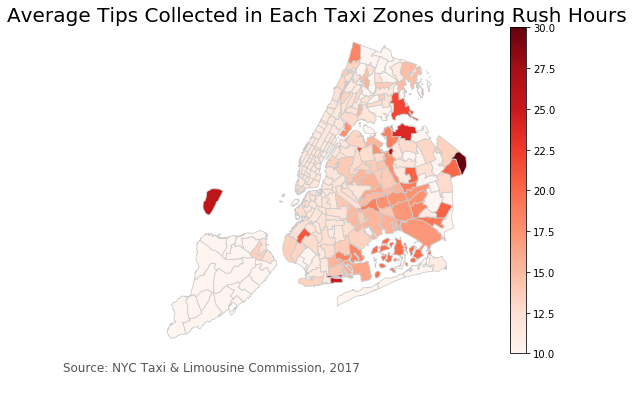

In [14]:
data_for_plot = final
data_for_plot

variable = 'avg_tips'

# set the range for the choropleth
vmin, vmax = 10, 30
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

ax.axis('off')

# add a title
ax.set_title('Average Tips Collected in Each Taxi Zones during Rush Hours', fontdict={'fontsize': '20', 'fontweight': '3'})
# create an annotation for the data source
ax.annotate('Source: NYC Taxi & Limousine Commission, 2017',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

data_for_plot.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()
fig.savefig('rushhour_choropleth.png', dpi=300)